In [2]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### 1) Data Description

The provided dataset for this assignment is ```players.csv``` and ```sessions.csv```.

```players```: 196 players, 7 variables\
```sessions```: 1535 sessions, 5 variables.

In [3]:
# reading the files
players <- read_csv('players.csv', show_col_types = FALSE)
sessions <- read_csv('sessions.csv', show_col_types = FALSE)

# quick overview of datasets
overview <- tibble(dataset = c("players.csv", "sessions.csv"),
                  n_rows = c(nrow(players), nrow(sessions)),
                  n_cols = c(ncol(players), ncol(sessions)))
overview

dataset,n_rows,n_cols
<chr>,<int>,<int>
players.csv,196,7
sessions.csv,1535,5


In ```players.csv```, each observation is **one player**, identified by ```hashedEmail```. Variable information is described below:

In [4]:
## variables in players.csv
players_variables <- tibble(variable = names(players), 
                            type = map_chr(players, ~class(.x)[1]),
                            description = c("Players's experience level (Amateur, Veteran, Pro)",
                                            "The player's subscription status to the newsletter",
                                            "The player's anonymized e-mail",
                                            "The total number of hours played",
                                            "The player's name",
                                            "The player's gender",
                                            "The player's age"))
players_variables

variable,type,description
<chr>,<chr>,<chr>
experience,character,"Players's experience level (Amateur, Veteran, Pro)"
subscribe,logical,The player's subscription status to the newsletter
hashedEmail,character,The player's anonymized e-mail
played_hours,numeric,The total number of hours played
name,character,The player's name
gender,character,The player's gender
Age,numeric,The player's age


Potential issues:

- ```min_hours = 0```: some players registered but never played. This indicates that some data might be missing.
- ```max_hours = 223.1```: data is positively skewed. Subsequently, ```mean_hours``` may be inflated.

- Some players did not report ```Age```. This could lead to bias and reduces the effective sample size. 

In [17]:
## summary statistics for played_hours and Age
hours_stats <- players |>
  summarise(min_hours = round(min(played_hours, na.rm = TRUE), 2),
    max_hours = round(max(played_hours, na.rm = TRUE), 2),
    mean_hours = round(mean(played_hours, na.rm = TRUE), 2),
    median_hours = round(median(played_hours, na.rm = TRUE), 2),
    total_players = n())

age_stats <- players |>
  summarise(min_age = round(min(Age, na.rm = TRUE), 2),
    max_age = round(max(Age, na.rm = TRUE), 2),
    mean_age = round(mean(Age, na.rm = TRUE), 2),
    median_age = round(median(Age, na.rm = TRUE), 2),
    total_players = n())

hours_stats
age_stats

min_hours,max_hours,mean_hours,median_hours,total_players
<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,223.1,5.85,0.1,196


min_age,max_age,mean_age,median_age,total_players
<dbl>,<dbl>,<dbl>,<dbl>,<int>
9,58,21.14,19,196


In ```sessions.csv```, each row is **one session**. ```hashedEmail``` is included per play session, so this information can be mapped back to ```players.csv```. There are 1535 observations and 5 variables:

In [18]:
sessions_variables <- tibble(variable = names(sessions),
                             type = map_chr(sessions, ~class(.x)[1]),
                             description = c("The player's anonymized e-mail",
                                             "session start time (dd/mm/yyyy hh/mm)",
                                             "session end time (dd/mm/yyyy hh/mm)",
                                             "UNIX start time",
                                             "UNIX end time"))
sessions_variables

variable,type,description
<chr>,<chr>,<chr>
hashedEmail,character,The player's anonymized e-mail
start_time,character,session start time (dd/mm/yyyy hh/mm)
end_time,character,session end time (dd/mm/yyyy hh/mm)
original_start_time,numeric,UNIX start time
original_end_time,numeric,UNIX end time


Potential problems:
- ```min_sessions = 1```, ```median_sessions = 1```, ```max_sessions = 310```. There is a positive skew and thus the mean may be inflated.
- Since ```median_sessions = 1```, individual player behaviour is unclear.

In [7]:
sessions_info <- sessions |>
    group_by(hashedEmail) |>
    summarise(count = n())

sessions_stats <- sessions_info |>
    summarise(min_sessions = min(count),
    max_sessions = max(count),
    mean_sessions = mean(count),
    median_sessions = median(count),
    total_players = n())

sessions_stats

min_sessions,max_sessions,mean_sessions,median_sessions,total_players
<int>,<int>,<dbl>,<int>,<int>
1,310,12.28,1,125


In [8]:
## histograms for played_hours and Age
hours_plot <- players |>
    ggplot(aes(x = played_hours)) +
    geom_histogram(bins = 50,
                   aes(y = after_stat(count/sum(count) * 100))) +
    labs(title = 'Distribution of Hours Played',
         x = 'Hours Played',
         y = 'Percent Total Players (%)') +
    theme(plot.title = element_text(hjust = 0.5))

age_plot <- players |>
    ggplot(aes(x = Age)) +
    geom_histogram(bins = 50,
                   aes(y = after_stat(count/sum(count) * 100))) +
    labs(title = 'Distribution of Player Age',
         x = 'Age (years)',
         y = 'Percent Total Players (%)') +
    theme(plot.title = element_text(hjust = 0.5))

### 2) Questions

**Broad Question 1**: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

**Specific Question**: Are players who play more often during certain times of day (mornings/afternoons/evenings) more likely to subscribe to the newsletter?

Predictor variabe: proportion of hours in morning/afternoon/night time windows. 
Reponse variable: ```subscribe```. This will be a **predictive classification** question because the outcome variable, ```subscribe```, is binary (or categorical).

### 3) Exploratory Data Analysis and Visualization

**1) Demonstrate that the dataset can be loaded into R**

In [9]:
players <- read_csv('players.csv', show_col_types = FALSE)
sessions <- read_csv('sessions.csv', show_col_types = FALSE)

head(players, 3)
head(sessions, 3)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12


**2) Do the minimum necessary wrangling to turn your data into a tidy format. Do not do any additional wrangling here; that will happen later during the group project phase**

In [10]:
glimpse(sessions)
sessions_tidy <- sessions |> 
    separate(start_time, into = c('start_date', 'start_time'), sep = ' ') |>
    separate(end_time, into = c('end_date', 'end_time'), sep = ' ')
head(sessions_tidy, 5)

Rows: 1,535
Columns: 5
$ hashedEmail         <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_time          <chr> "30/06/2024 18:12", "17/06/2024 23:33", "25/07/202…
$ end_time            <chr> "30/06/2024 18:24", "17/06/2024 23:46", "25/07/202…
$ original_start_time <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…
$ original_end_time   <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…


hashedEmail,start_date,start_time,end_date,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024,18:12,30/06/2024,18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024,23:33,17/06/2024,23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024,17:34,25/07/2024,17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024,03:22,25/07/2024,03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024,16:01,25/05/2024,16:12,1.71665e+12,1.71665e+12


**3) Compute the mean value for each quantitative variable in the players.csv data set. Report the mean values in a table format.**

In [11]:
glimpse(players)

players_summary <- players |>
    summarise(
        mean_hours = round(mean(played_hours, na.rm = TRUE), 2),
        mean_age = round(mean(Age, na.rm = TRUE),2))
players_summary

Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <dbl> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…


mean_hours,mean_age
<dbl>,<dbl>
5.85,21.14


**4) Make a few exploratory visualizations of the data to help you understand it**

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


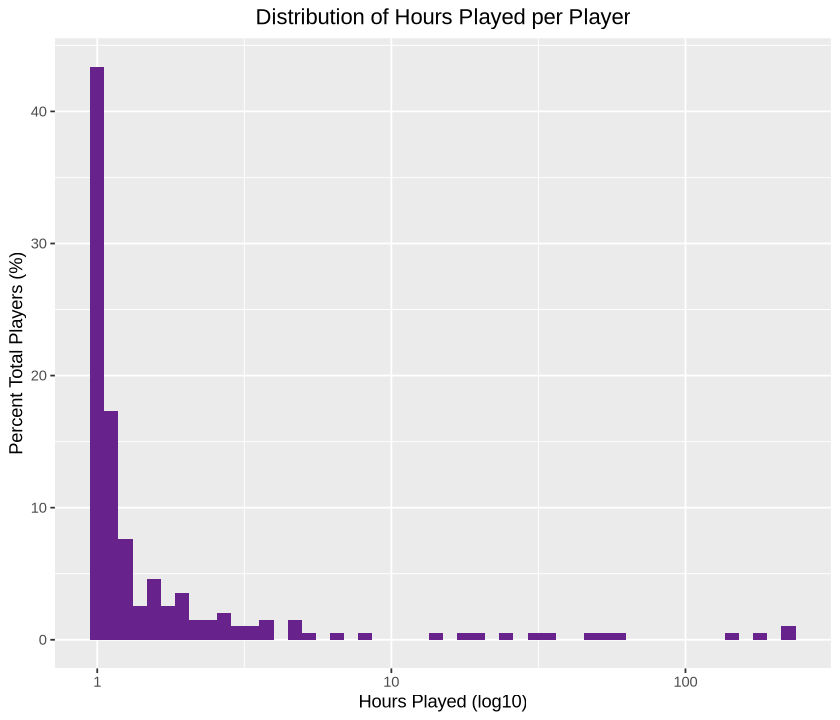

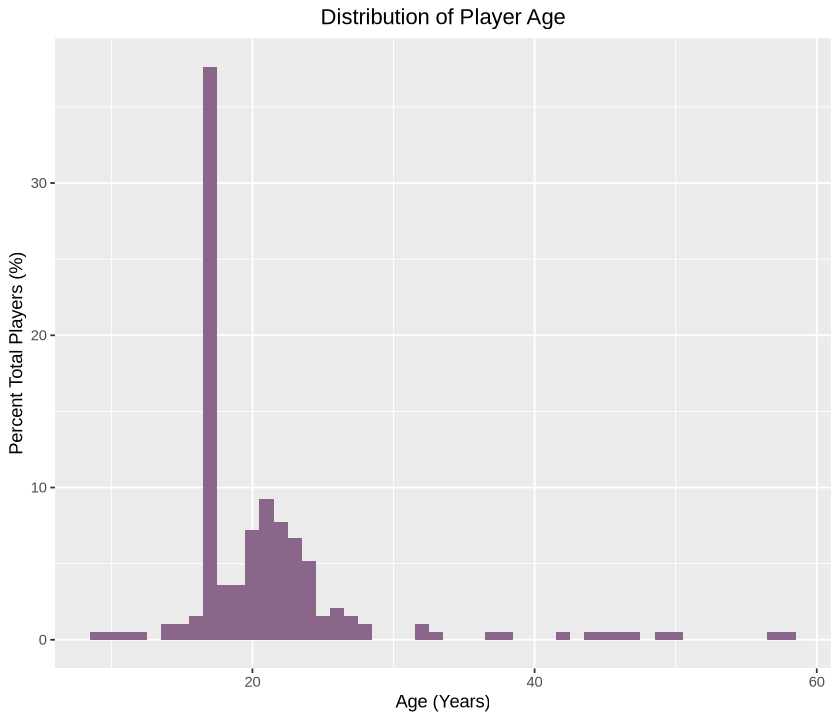

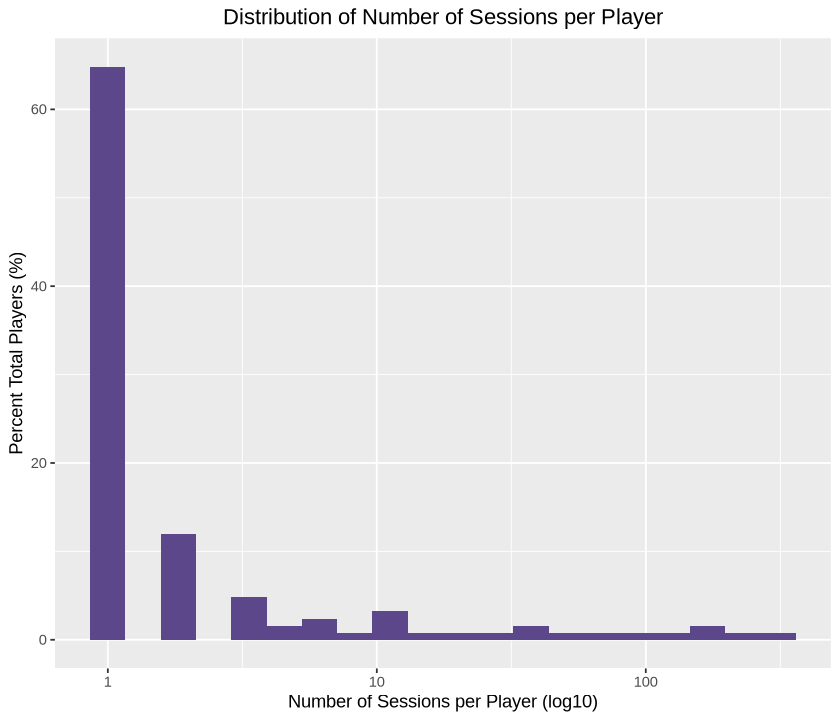

In [12]:
options(repr.plot.width = 7, repr.plot.height = 6)

## create histogram of hours played per player
hours_hist <- players |>
    ggplot(aes(x = played_hours + 1)) +
    geom_histogram(bins = 50,
                   aes(y = after_stat(count/sum(count) * 100)),
                  fill = 'darkorchid4') +
    labs(title = 'Distribution of Hours Played per Player',
         x = 'Hours Played (log10)',
         y = 'Percent Total Players (%)') +
    scale_x_log10() +
    theme(plot.title = element_text(hjust = 0.5))
hours_hist

## create histogram of players' ages
age_hist <- players |>
    ggplot(aes(x = Age)) +
    geom_histogram(bins = 50,
                   aes(y = after_stat(count/sum(count) * 100)),
                  fill = 'plum4') +
    labs(title = 'Distribution of Player Age',
         x = 'Age (Years)',
         y = 'Percent Total Players (%)') +
    theme(plot.title = element_text(hjust = 0.5))
age_hist

## create histogram of number of sessions per player
sessions_hist <- sessions_info |>
  ggplot(aes(x = count)) +
  geom_histogram(bins = 20,
                aes(y = after_stat(count/sum(count) * 100)),
                fill = 'mediumpurple4') + 
    scale_x_log10() +
    labs(title = 'Distribution of Number of Sessions per Player',
         x = 'Number of Sessions per Player (log10)',
         y = 'Percent Total Players (%)') + 
    theme(plot.title = element_text(hjust = 0.5))
sessions_hist

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


subscribe,n,pct
<lgl>,<int>,<dbl>
FALSE,52,26.53
TRUE,144,73.47


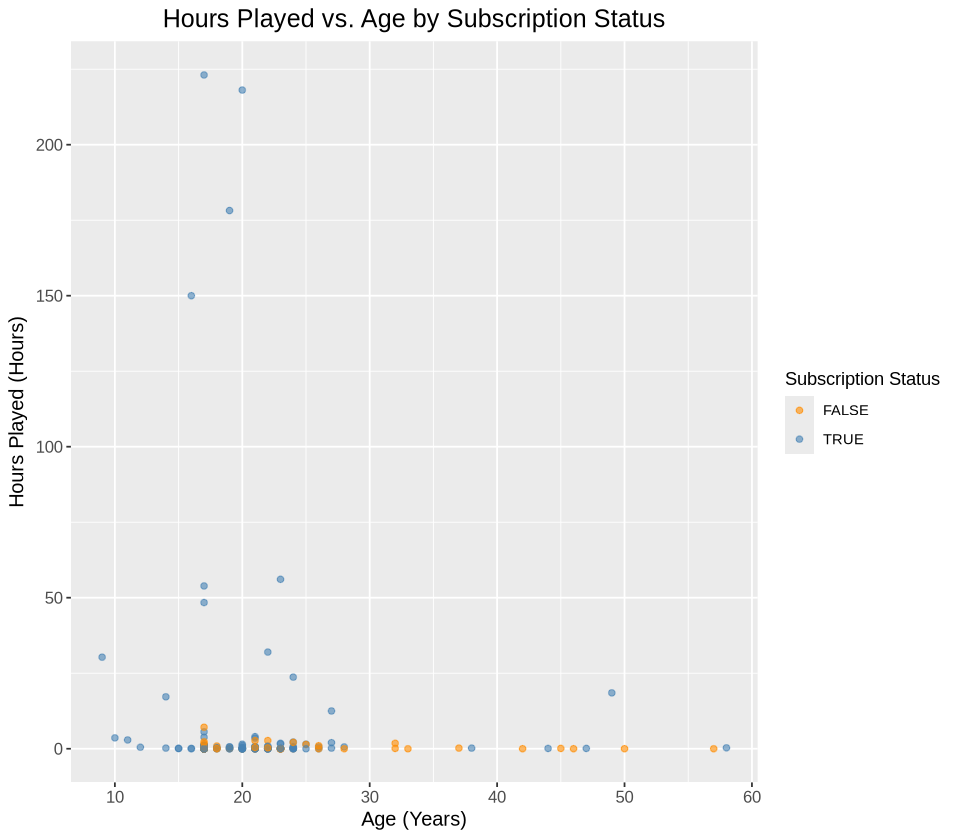

In [13]:
options(repr.plot.height = 7, repr.plot.width = 8)

## create plot of hours played vs age, group by subscription status
age_hours_plot <- players |> 
    ggplot(aes(x = Age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.6) + 
    labs(title = 'Hours Played vs. Age by Subscription Status', 
         x = 'Age (Years)',
         y = 'Hours Played (Hours)',
        color = 'Subscription Status') + 
    theme(plot.title = element_text(size = 15, hjust = 0.5),
         axis.title = element_text(size = 12),
         axis.text = element_text(size = 10)) +
    scale_color_manual(values = c('darkorange', 'steelblue'))

age_hours_plot

## summarise pct players where subscribe = TRUE/FALSE:
pct_true <- players |>
  count(subscribe) |>
  mutate(pct = round(n/sum(n)*100, 2))
pct_true

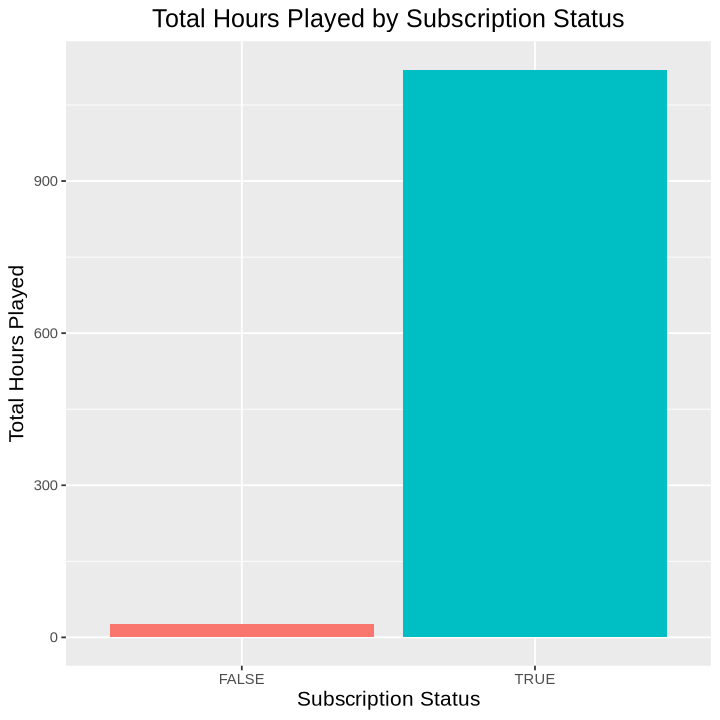

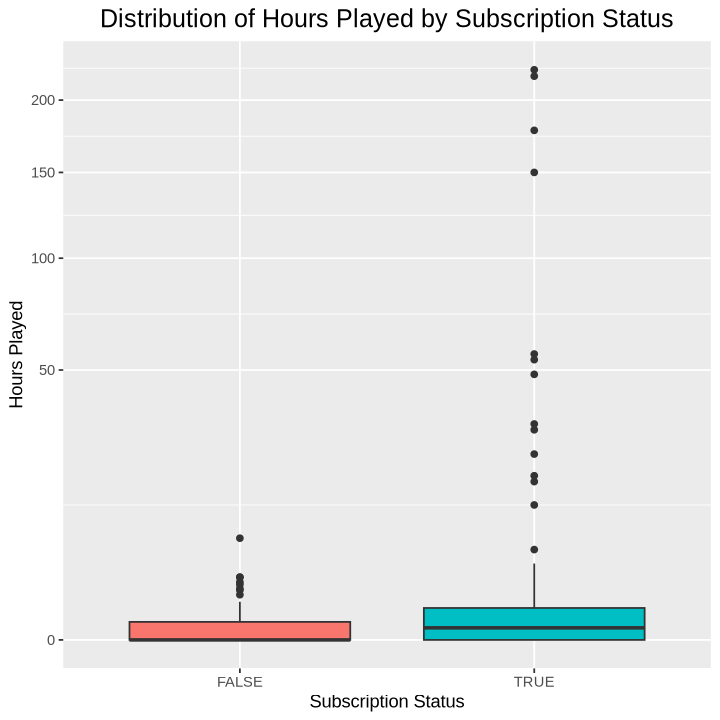

In [16]:
options(repr.plot.height = 6, repr.plot.width = 6)
## create bar chart
sub_hours_bar <- players |>
    ggplot(aes(x = subscribe, y = played_hours, fill = subscribe)) +
    geom_bar(stat = "identity") +
    labs(title = "Total Hours Played by Subscription Status",
         x = "Subscription Status", 
         y = "Total Hours Played") +
    theme(plot.title = element_text(hjust = 0.5, size = 15),
          axis.title = element_text(size = 12.5),
         legend.position = 'none')
sub_hours_bar


## create box plot
sub_hours_box <- players |> 
    ggplot(aes(x = subscribe, y = played_hours, fill = subscribe)) +
    geom_boxplot() +
    labs(title = "Distribution of Hours Played by Subscription Status",
         x = "Subscription Status",
         y = "Hours Played") + 
    scale_y_sqrt() +
    theme(plot.title = element_text(hjust = 0.5, size = 15),
         legend.position = "none")
sub_hours_box

## 4) Methods and Plan

**Why is this method appropriate?**\
This method is appropriate because it uses a classification approach to predict a a binary ```subscribe = TRUE/FALSE``` outcome. Classification is suitable when the response variable is categorical.

**Which assumptions are required, if any, to apply the method selected?**\
To apply this model, assumptions include:
- The sample size is large enough to reliably train the model
- The response variable is categorical
- Player behaviours/observations are all **independent** of each other

**What are the potential limitations or weaknesses of the method selected?**
- The dataset is relatively small, so it may not actually be truly be generalizable to new players.
- There may be some bias in the players in the dataset, as those who are more active may be more likely to participate, and similarly, subscribe.

**How are you going to compare and select the model?**\
**How are you going to process the data to apply the model? For example: Are you splitting the data? How? How many splits? What proportions will you use for the splits? At what stage will you split? Will there be a validation set? Will you use cross validation?**

Following the process learned in class, the goal is to assess how well my model performs on unseen data (beyond the training set). After fitting the model on training data, the model's performance will be evaluated and compared using **accuracy**, **precision**, and **recall**. I will generate a confusion matrix to summarize the types of correct/misclassifications made by the model, and examine its performance. Additionally, I will use an AUC-ROC curve to compare between models. I will select the final model based on average performance on 5 cross-validation folds. 

A high level workflow is as follows:
- The ```sessions``` dataset has multiple rows per player. I will calculate the **proportion** of hours in a time category by extracting the hours from ```start_time``` and ```end_time```. I will then merge this data with ```players```, which contains the variables of interest (```subscribe```).
- After wrangling/cleaning thed data, I will split the data into **80% training** and **20% testing** using ```initial_split()```. I will perform **5-fold cross-validation** using ```vfold_cv()```. 
- The training data will be used to fit the model. The test data will be held until the end, and used to evaluate the model. 

